![Captioning](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/caption-1.png "Captioning")  
[source](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/caption-1.png)

## Transformer-based caption generation
<hr>

**Caption generation** is the automated process of creating precise, grammatically sound descriptions for images. It requires recognizing essential objects, actions, and contextual elements within an image, then articulating them in natural language. This task bridges the fields of computer vision and natural language processing, leveraging a vision model to analyze image features and a language model to craft meaningful descriptive text.

The diagram provides a high-level overview: a pre-trained computer vision model (such as a CNN) first extracts image features, which are then fed into a language model to generate captions sequentially, word by word.

## Imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Image
import torch
from torch import nn
from torch.utils.data import DataLoader
import math
from PIL import Image as PIL_Image
from tqdm import tqdm, trange

**Tools we will use:**

- `PyTorch` 
- [Hugging Face Transformers](https://huggingface.co/)
- [Pre-trained CNN models]()

The image captioning task consists of several key components, which we will divide into six distinct tasks:
- **TASK 1:** Extract image features using pre-trained vision models.
- **TASK 2:** Tokenize captions using pre-trained language models.
- **TASK 3:** Create a PyTorch dataset for training.
- **TASK 4:** Implement the `ImageCaptioning` class, which uses the transformer architecture for caption generation.
- **TASK 5:** Write the PyTorch training loop to train the model.
- **TASK 6:** Generate captions and evaluate the generated captions.


We will train the model using [the flickr8k dataset](https://www.kaggle.com/datasets/adityajn105/flickr8k). The training task will be computationally expensive. We may opt to use Kaggle notebooks, which offer free access to strong GPUs for up to 30 hours per week.

In [15]:
# The folder containing the data 
# image_folder = "flickr8k"

# If you run the notebook on Kaggle, you can use the following line
image_folder = "/kaggle/input/flickr8k"

In [16]:
# Read and show the first few lines of caption.txt 
df = pd.read_csv(f"{image_folder}/captions.txt", sep=',')
df.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .


In [17]:
# Set the appropriate device depending upon your hardware. 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu') 
print(device)

cuda


### TASK 1: Extracting image features using pre-trained vision models
The initial step in the image captioning process involves extracting image features. This is commonly achieved by extracting the output from the final linear layer of a Convolutional Neural Network (CNN). Instead of building our own CNN from scratch, we will use a pre-trained CNN model.

In [ ]:
import torch
from transformers import AutoFeatureExtractor, ResNetModel

class ImageFeatureExtractor:
    """Extracts image features using a pretrained ResNet model."""

    def __init__(self, device, model_name="microsoft/resnet-18"):
        self.device = device
        self.feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)
        self.resnet_model = ResNetModel.from_pretrained(model_name).to(device)
        self.resnet_model.eval()

    def __call__(self, image) -> torch.Tensor:
        """Returns a (1, 512) tensor of features extracted from the input image."""
        
        inputs = self.feature_extractor(images=image, return_tensors="pt").to(self.device)

        # Extract features using the ResNet model
        with torch.no_grad():  # Disable gradient calculation
            outputs = self.resnet_model(**inputs)

        # Retrieve the features after the final pooling layer
        features = outputs.pooler_output

        # Ensure the feature shape is (1, 512)
        features = features.view(1, -1)

        # Return the features, moved back to CPU for processing compatibility
        return features.cpu()


2025-04-20 19:01:08.624519: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745175668.808479      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745175668.861678      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
# Now let's open an image 
image = PIL_Image.open('{}/Images/{}'.format(image_folder, df.iloc[34396].image))
image

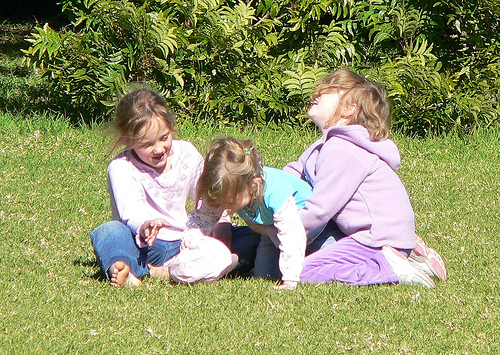

In [ ]:
feature_extractor = ImageFeatureExtractor(device=device) # We'll need this later

### TASK 2: Implement a tokenizer using pre-trained language models

Next, we'll preprocess text data by tokenizing it using Hugging Face's [AutoTokenizer](https://huggingface.co/transformers/v3.0.2/model_doc/auto.html#autotokenizer), specifically the `bert-base-cased` model. Since the vocabulary of `bert-base-cased` is significantly larger than that of our captions dataset, we'll create a wrapper class for `AutoTokenizer` to define custom token-to-vocabulary mappings.

In [ ]:
from transformers import AutoTokenizer
from tqdm import trange

class TokenizerWrapper:
    """Wraps AutoTokenizer with a custom vocabulary mapping."""

    def __init__(self, model_name="bert-base-cased"):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        
        # Initialize mappings with special tokens: [PAD] -> 0, [CLS] -> 1, [SEP] -> 2
        self.token_id_to_vocab_id = {0: 0, 101: 1, 102: 2}
        self.vocab_id_to_token_id = {0: 0, 1: 101, 2: 102}
        
        self.vocab_id = 3  # Start after special tokens
        self.padding_len = None

    def build_dictionary(self, captions: list[str]):
        """Builds vocabulary from a list of captions and sets padding length."""
        tokenized = self.tokenizer(captions, padding='longest').input_ids
        self.padding_len = len(tokenized[0])

        for tokens in tokenized:
            for token_id in tokens:
                if token_id not in self.token_id_to_vocab_id:
                    self.token_id_to_vocab_id[token_id] = self.vocab_id
                    self.vocab_id_to_token_id[self.vocab_id] = token_id
                    self.vocab_id += 1

    def get_vocab_size(self) -> int:
        """Returns the size of the custom vocabulary."""
        assert len(self.token_id_to_vocab_id) == len(self.vocab_id_to_token_id)
        return self.vocab_id

    def tokenize(self, text: str) -> list[int]:
        """Tokenizes text using custom vocabulary (requires build_dictionary first)."""
        assert self.padding_len is not None, "Call build_dictionary() before tokenizing."
        token_ids = self.tokenizer(text, padding='max_length', max_length=self.padding_len).input_ids
        return [self.token_id_to_vocab_id[token_id] for token_id in token_ids]

    def decode(self, vocab_ids: list[int]) -> str:
        """Decodes a list of custom vocab IDs into a string."""
        token_ids = [self.vocab_id_to_token_id[vocab_id] for vocab_id in vocab_ids]
        # Using `self.tokenizer.decode` to convert a list of token IDs back into a text string.
        text = self.tokenizer.decode(token_ids)
        return text.replace('[CLS] ', '').replace(' [SEP]', '').replace(' [PAD]', '')


In [ ]:
# Build the dictionary for our tokenizer  
tokenizer_wrapper = TokenizerWrapper()
tokenizer_wrapper.build_dictionary(df["caption"].to_list())

In [23]:
# What's the size of our custom vocabulary
tokenizer_wrapper.get_vocab_size() 

7501

In [24]:
tokenizer_wrapper.tokenizer.vocab_size

28996

In [ ]:
# let's try to tokenize the caption corresponding to the image we saw in the last task, 
# and decode the tokens back to the caption

caption_tokens = tokenizer_wrapper.tokenize(df.iloc[34396].caption)
decoeded_caption = tokenizer_wrapper.decode(caption_tokens)
print('Caption:', df.iloc[34396].caption)
print('Tokens:', caption_tokens)
print('Decoded caption:', decoeded_caption)

# Our Caption and the Decoded caption should match here. 

Caption: Three children sit on the grass .
Tokens: [1, 405, 506, 294, 45, 27, 72, 18, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Decoded caption: Three children sit on the grass.


### TASK 3: Data splitting and creating a Pytorch dataset
#### Part 1: Data splitting

Up to this point, we've developed an image feature extractor to generate feature vectors from images and a tokenizer to encode captions into meaningful representations. Now, it's time to prepare our data for model training and evaluation.  

Let's start by dividing the dataset into training and testing subsets.

In [26]:
import pandas as pd
import numpy as np

def train_test_split_by_image(data_df, sample_size=None, train_ratio=0.8, seed=100):
    """
    Splits the dataframe into training and testing datasets based on unique images.
    
    Parameters:
        data_df (pandas.DataFrame): The dataset to split, containing at least 'image' and 'caption' columns.
        sample_size (int): The number of samples to consider. Useful during prototyping.
        train_ratio (float): The proportion of the dataset to allocate to the training set.
        seed (int): Seed for random number generator for reproducibility.

    Returns:
        train_df (pandas.DataFrame): Training dataset.
        test_df (pandas.DataFrame): Testing dataset.
    """
    np.random.seed(seed)
    unique_images = np.random.permutation(data_df['image'].unique())

    if sample_size:
        unique_images = unique_images[:sample_size]

    split_point = int(len(unique_images) * train_ratio)
    train_images, test_images = unique_images[:split_point], unique_images[split_point:]

    train_df = data_df[data_df['image'].isin(train_images)]
    test_df = data_df[data_df['image'].isin(test_images)]

    return train_df, test_df

In [ ]:
# Using a sample of the data for prototyping 
train_df, test_df = train_test_split_by_image(df, sample_size = 100, train_ratio=0.8)
print(f'The number of rows in the training set is {train_df.shape[0]} and the number of unique images is {int(train_df.shape[0]/5)}')
print(f'The number of rows in the test set is {test_df.shape[0]} and the number of unique images is {int(test_df.shape[0]/5)}')
train_df.head()

The number of rows in the training set is 400 and the number of unique images is 80
The number of rows in the test set is 100 and the number of unique images is 20


,image,caption
295,1077546505_a4f6c4daa9.jpg,A boy in blue shorts slides down a slide into a pool .
296,1077546505_a4f6c4daa9.jpg,A boy in blue swimming trunks slides down a yellow slide into a wading pool with inflatable toys floating in the water .
297,1077546505_a4f6c4daa9.jpg,A boy rides down a slide into a small backyard pool .
298,1077546505_a4f6c4daa9.jpg,A boy sliding down a slide into a pool with colorful tubes .
299,1077546505_a4f6c4daa9.jpg,A child is falling off a slide onto colored balloons floating on a pool of water .


In [ ]:
# Using the entire dataset
train_df, test_df = train_test_split_by_image(df, train_ratio=0.8)
print(f'The number of rows in the training set is {train_df.shape[0]} and the number of unique images is {train_df.shape[0]/5}')
print(f'The number of rows in the test set is {test_df.shape[0]} and the number of unique images is {test_df.shape[0]/5}')
train_df.head()

The number of rows in the training set is 32360 and the number of unique images is 6472.0
The number of rows in the test set is 8095 and the number of unique images is 1619.0


,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .


Now that we have train and test datasets, the next steps involve processing each image and caption in both the training and testing sets while ensuring efficient batch loading and handling with PyTorch. To accomplish this, we'll first write a function called `build_data` that converts the data into a torch tensor. After that, we'll implement a class named `PytorchDataset` to construct a PyTorch dataset, making data management more streamlined.

#### Part 2: creating a Pytorch dataset

In [ ]:
def build_data(data_df, tokenizer_wrapper, feature_extractor, image_folder):
    """
    Constructs a dataset list from provided image and caption data.

    This function processes each entry in a dataframe, extracts image features using a specified
    feature extractor, tokenizes captions using a tokenizer wrapper, and combines these elements into
    a list where each item is a dictionary containing image features and tokenized caption data.

    Parameters:
        data_df (pandas.DataFrame): A dataframe containing at least two columns: 'image' and 'caption'.
            - 'image' column contains filenames of images.
            - 'caption' column contains the corresponding captions for the images.
        tokenizer_wrapper (TokenizerWrapper): An object encapsulating a tokenizer that provides
            a method 'tokenize' to convert text captions into token ids.
        feature_extractor (Callable): A function or callable object that accepts an image object and
            returns a tensor representing extracted features from the image.
        image_folder (str): The path to the folder where images are stored. The path should not
            end with a slash. It is assumed that images are stored within an 'Images' subfolder.

    Returns:
        list: A list of dictionaries, where each dictionary has two keys:
            - 'image': a tensor containing features of the image.
            - 'token': a tensor of token ids derived from the caption.

    Example:
        Assuming 'data_df' has two columns 'image' and 'caption' where 'image' contains filenames:
        >>> data_df = pd.DataFrame({
        ...     'image': ['image1.jpg', 'image2.jpg'],
        ...     'caption': ['A cat on a mat.', 'A dog in the fog.']
        ... })
        >>> dataset = build_data(data_df, tokenizer_wrapper, feature_extractor, '/path/to/images')
        >>> print(dataset[0]['image'])  # Outputs the tensor of image features for 'image1.jpg'
        >>> print(dataset[0]['token'])  # Outputs the tensor of token ids for 'A cat on a mat.'
    """    

    dataset = []
    for i in trange(len(data_df)):
        row = data_df.iloc[i]
        image_path = f"{image_folder}/Images/{row.image}"
        image = PIL_Image.open(image_path)

        # Get image features 
        image_features = feature_extractor(image)

        # Get caption tokens
        caption_tokens = torch.tensor(tokenizer_wrapper.tokenize(row.caption))
        
        dataset.append({'image': image_features, 'token': caption_tokens})
    return dataset
    

Let's create train and test datasets by calling `build_data` on train and test splits. 
Note: This will take some time to run, as we are processing all images and captions in the dataset. 

In [30]:
train_data = build_data(train_df, tokenizer_wrapper, feature_extractor, image_folder)
test_data = build_data(test_df, tokenizer_wrapper, feature_extractor, image_folder)

100%|██████████| 8095/8095 [01:53<00:00, 71.43it/s]


In [ ]:
# Get the dimension of the image feature
image_dim = train_data[0]['image'].shape[-1]
vocab_size = tokenizer_wrapper.get_vocab_size()
print(f'Image feature dimension is {image_dim}. The vocab size is {vocab_size}.')

# our image_dim should pass this test
assert isinstance(image_dim, int)

Image feature dimension is 512. The vocab size is 7501.


Now let's buid our PyTorch dataset. 

In [32]:
class PytorchDataset:
    """
    A PyTorch-compatible dataset that returns:
    - the original token sequence,
    - image features,
    - and the target sequence (input shifted left with padding at the end).
    """

    def __init__(self, data, pad_vocab_id=0):
        self.data = data
        self.pad_token = torch.tensor([pad_vocab_id])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        tokens = self.data[idx]['token']
        image = self.data[idx]['image']
        target = torch.cat([tokens[1:], self.pad_token])
        return tokens, image, target


In [33]:
train_dataset = PytorchDataset(train_data)
test_dataset = PytorchDataset(test_data)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=50, shuffle=False)

In [ ]:
# Now let's get the first data from PytorchDataset
train_token, train_image, train_target = train_dataset[0]

# our dataset should pass these tests
assert train_token.shape == train_target.shape
assert torch.all(train_token[1:] == train_target[:-1]).item()

In [35]:
# Shape of the image features
train_image.shape

torch.Size([1, 512])

In [36]:
# Numericalized caption
train_token 

tensor([ 1,  3,  4,  5,  6,  7,  8,  9, 10, 11,  6, 12, 13, 14,  5, 15, 16, 17,
        18,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0])

In [37]:
# decoded caption
tokenizer_wrapper.decode(train_token.tolist()) 

'A child in a pink dress is climbing up a set of stairs in an entry way.'

In [38]:
# the target of the train_token (i.e., training example) 
train_target

tensor([ 3,  4,  5,  6,  7,  8,  9, 10, 11,  6, 12, 13, 14,  5, 15, 16, 17, 18,
         2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0])

In [39]:
# decoded caption
tokenizer_wrapper.decode(train_target.tolist()) 

'A child in a pink dress is climbing up a set of stairs in an entry way.'

The decoded caption is the same for input and target because the special token [CLS] with token ID 1 is **not** displayed in the decoded caption. 

<br><br>

In [40]:
# Now let's get a batch of data from DataLoader
train_text, train_image, train_target = next(iter(train_dataloader))
train_text = train_text.to(device)
train_image = train_image.to(device)

assert train_image.ndim == 3
assert train_text.ndim == 2

In [41]:
train_text.shape # batch_size, max_len

torch.Size([64, 43])

In [42]:
train_image.shape

torch.Size([64, 1, 512])

In [43]:
train_target.shape # batch_size, max_len

torch.Size([64, 43])

### TASK 4: Implementing the image captioning model using PyTorch
<hr>

To summarize our model's architecture, image features are first projected into the embedding space via self.image_embedding and then reshaped to serve as the decoder's memory. Token IDs undergo embedding through self.text_embedding and are further enriched with positional information using self.pos_encoding. These processed inputs are then fed into the TransformerDecoder, where context-aware token representations are generated. The decoder’s output is passed through linear_layer to compute vocabulary logits, followed by a softmax function to derive token probabilities. During inference, a token is sampled from this distribution and used to generate the subsequent word.

The `PositionalEncoding` class adds sinusoidal positional encodings to input embeddings, helping the Transformer model understand word order in a sequence. Since Transformers lack inherent sequential processing, this encoding is crucial for generating structured captions in our image captioning task.

In [ ]:
class PositionalEncoding(nn.Module):
    """
    Implements sinusoidal positional encoding as described in "Attention is All You Need".

    Args:
        d_model (int): Dimension of the embedding space.
        dropout (float): Dropout rate after adding positional encodings.
        max_len (int): Maximum length of supported input sequences.
    """
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Create a (max_len, 1) position tensor: [[0], [1], ..., [max_len-1]]
        positions = torch.arange(max_len).unsqueeze(1)

        # Compute the scaling terms for each dimension (even indices only)
        scale_factors = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))

        # Initialize the positional encoding matrix with shape (max_len, 1, d_model)
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(positions * scale_factors)  # Apply sine to even indices
        pe[:, 0, 1::2] = torch.cos(positions * scale_factors)  # Apply cosine to odd indices

        # Register as buffer (not a trainable parameter)
        self.register_buffer("pe", pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Adds positional encoding to the input tensor.

        Args:
            x (torch.Tensor): Input tensor of shape (seq_len, batch_size, d_model)

        Returns:
            torch.Tensor: Tensor with positional encoding added.
        """
        seq_len = x.size(0)
        x = x + self.pe[:seq_len]
        return self.dropout(x)

Now we are ready to define our own transformer model tailored for image captioning! 

In [ ]:
class ImageCaptionModel(nn.Module):
    def __init__(self, d_model, n_heads, num_layers, image_dim, vocab_size, device, dropout=0.1):
        """
        Initialize the ImageCaptionModel which uses a transformer decoder architecture
        for generating image captions.

        Parameters:
            d_model (int): The number of expected features in the encoder/decoder inputs.
            n_heads (int): The number of heads in the multiheadattention models.
            num_layers (int): The number of sub-decoder-layers in the transformer.
            image_dim (int): The dimensionality of the input image features.
            vocab_size (int): The size of the vocabulary.
            device (torch.device): The device on which the model will be trained.
            dropout (float): The dropout value used in PositionalEncoding and TransformerDecoderLayer.
        """        
        super(ImageCaptionModel, self).__init__()
        self.d_model = d_model
        self.device = device
        # Positional Encoding to add position information to input embeddings
        self.pos_encoding = PositionalEncoding(d_model=d_model, dropout=dropout)

        # Here is our transformer architecture
        
        # Transformer Decoder to generate captions from image features and text inputs
        self.TransformerDecoder = nn.TransformerDecoder(
            decoder_layer=nn.TransformerDecoderLayer(d_model=d_model, nhead=n_heads, dropout=dropout), 
            num_layers=num_layers
        )

        # Linear layer to convert image features to a dimensionality that matches the model's
        self.image_embedding = nn.Linear(image_dim , d_model)

        # Embedding layer for converting input text tokens into vectors
        self.text_embedding = nn.Embedding(vocab_size , d_model)

        # Final linear layer to map the output of the transformer decoder to vocabulary size        
        self.linear_layer = nn.Linear(d_model, vocab_size)

        # Initialize the weights of the model
        self.init_weights()
        
    def init_weights(self):
        """
        Initialize weights of the model to small random values.
        """
        initrange = 0.1
        self.text_embedding.weight.data.uniform_(-initrange, initrange)
        self.image_embedding.weight.data.uniform_(-initrange, initrange)
        self.linear_layer.bias.data.zero_()
        self.linear_layer.weight.data.uniform_(-initrange, initrange)
        
    def forward(self, image, text):
        """
        Defines the forward pass of the model.

        Parameters:
            image (Tensor): The tensor containing image features.
            text (Tensor): The tensor containing input text tokens.

        Returns:
            Tensor: The output tensor containing the logit scores for each vocabulary token.
        """                
        # Convert image features to match the dimensionality of the model
        encoded_image = self.image_embedding(image)
        encoded_image = encoded_image.permute(1,0,2)

        # Convert text tokens into embeddings and apply positional encoding
        encoded_text = self.text_embedding(text) * math.sqrt(self.d_model)        
        encoded_text = encoded_text.permute(1,0,2)        
        encoded_text = self.pos_encoding(encoded_text)
        
        # Get the length of the sequences to be decoeded. This is needed to generate the causal masks
        seq_len = encoded_text.size(0)  

        # Generate a causal mask to prevent the model from attending to future tokens
        causal_mask = (torch.triu(torch.ones(seq_len, seq_len)) == 1).transpose(0, 1)
        causal_mask = causal_mask.float().masked_fill(causal_mask == 0, float('-inf')).masked_fill(causal_mask == 1, float(0.0))
        causal_mask = causal_mask.to(self.device)

        # Process through the transformer decoder
        transformer_output = self.TransformerDecoder(tgt=encoded_text, memory=encoded_image, tgt_mask=causal_mask) 

        # Apply the final linear layer to produce predictions for each token
        final_layer_output = self.linear_layer(transformer_output) 
        return final_layer_output

In [ ]:
# Now let's try the model. 
# Feel free to change these hyperparameters. 
d_model = 256 
n_heads = 4
num_layers = 8
model = ImageCaptionModel(d_model=d_model, n_heads=n_heads, num_layers=num_layers, image_dim=image_dim, vocab_size=vocab_size, device=device).to(device)

In [ ]:
# pass inputs to the model
output = model(train_image, train_text)

# output should pass the test
assert output.shape == (train_text.shape[1], train_text.shape[0], vocab_size)

### 2.5 TASK 5: Implement the training loop
The next step is to train our `ImageCaptionModel` using the dataset we've prepared. We are defining the optimizer and the loss function below. 

In [ ]:
# Feel free to change the hyperparameters. 

num_epoch = 30
clip_norm = 1.0
lr = 5e-5

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss(ignore_index=0) # Ignore the padding index

In [ ]:
def trainer(model, criterion, optimizer, train_dataloader, test_dataloader, epochs=5, patience=5):
    """
    Trains and evaluates a model using the specified dataloaders, optimizer, and loss criterion with early stopping.
    """    
    train_losses = []
    test_losses = []
    consec_increases = 0        
    
    for epoch in range(epochs):
        sum_train_loss = 0
        sum_test_loss = 0
        num_train_loss = 0        
        num_test_loss = 0

        # Set model to training mode
        model.train()

        for train_text, train_image, target_seq in train_dataloader:

            train_text = train_text.to(device)
            train_image = train_image.to(device)
            target_seq = target_seq.to(device)

            # Forward pass
            output = model(train_image, train_text) 
            output = output.permute(1, 2, 0) 
            train_loss = criterion(output, target_seq) 

            # Backward pass 
            optimizer.zero_grad()        
            train_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_norm)
            optimizer.step()

            # Book keeping 
            sum_train_loss += torch.sum(train_loss).detach().item()
            num_train_loss += 1 

        # Set the model to evaluation mode
        model.eval()
        with torch.no_grad():
            for test_text, test_image, target_seq in test_dataloader:
                test_text = test_text.to(device)
                test_image = test_image.to(device)
                target_seq = target_seq.to(device)

                # Forward pass
                output = model(test_image, test_text) 
                output = output.permute(1, 2, 0) 
                test_loss = criterion(output, target_seq)
                
                # Book keeping 
                sum_test_loss += torch.sum(test_loss).detach().item()
                num_test_loss += 1

        # Calculate and store average losses
        avg_train_loss = sum_train_loss / num_train_loss
        avg_test_loss = sum_test_loss / num_test_loss
        train_losses.append(avg_train_loss)
        test_losses.append(avg_test_loss)
        print(f"Epoch {epoch+1}: Train Loss {avg_train_loss:.2f}, Test Loss {avg_test_loss:.2f}")

        # Early stopping
        if epoch > 0 and test_losses[-1] > test_losses[-2]:
            consec_increases += 1
        else:
            consec_increases = 0
        if consec_increases == patience:
            print(f"Stopped early at epoch {epoch + 1} - test loss increased for {consec_increases} consecutive epochs!")
            break
            
    return train_losses, test_losses
        

In [ ]:
# Warning: This may take a while to run.
train_losses, test_losses = trainer(model, criterion, optimizer,train_dataloader, test_dataloader, epochs= num_epoch)

Epoch 1: Train Loss 5.41, Test Loss 4.39
Epoch 5: Train Loss 3.42, Test Loss 3.41
Epoch 6: Train Loss 3.28, Test Loss 3.30
Epoch 7: Train Loss 3.15, Test Loss 3.22
Epoch 8: Train Loss 3.05, Test Loss 3.17
Epoch 9: Train Loss 2.96, Test Loss 3.11
Epoch 10: Train Loss 2.88, Test Loss 3.06
Epoch 11: Train Loss 2.80, Test Loss 3.03
Epoch 12: Train Loss 2.74, Test Loss 2.99
Epoch 13: Train Loss 2.67, Test Loss 2.97
Epoch 14: Train Loss 2.62, Test Loss 2.95
Epoch 15: Train Loss 2.56, Test Loss 2.93
Epoch 16: Train Loss 2.51, Test Loss 2.91
Epoch 17: Train Loss 2.46, Test Loss 2.90
Epoch 18: Train Loss 2.41, Test Loss 2.89
Epoch 22: Train Loss 2.24, Test Loss 2.87
Epoch 23: Train Loss 2.20, Test Loss 2.86
Epoch 24: Train Loss 2.16, Test Loss 2.87
Epoch 25: Train Loss 2.12, Test Loss 2.87
Epoch 26: Train Loss 2.08, Test Loss 2.87
Epoch 27: Train Loss 2.04, Test Loss 2.87
Epoch 28: Train Loss 2.01, Test Loss 2.88
Epoch 29: Train Loss 1.97, Test Loss 2.88
Epoch 30: Train Loss 1.94, Test Loss 2.8

    
## TASK 6: Generate captions using the trained model
Now that we have trained our model, the moment of truth has arrived! The final task is generating captions using `ImageCaptionModel`.

In [ ]:
def get_test_data(index): 
    """
    Retrieve the text and image data from the test dataset at the specified index.

    Parameters:
        index (int): The index of the test dataset from which to fetch the data.

    Returns:
        tuple: A tuple containing:
            - test_text (Tensor): The tensor representing the caption.
            - test_image (Tensor): The tensor representing the image.
    """    
    test_text, test_image, target_seq = test_dataset[index]
    return test_text, test_image
    
def generate_caption(model, image, device, max_caption_length=100, start_vocab=1, end_vocab=2):
    """
    Generates a caption for an image using the specified model and device.

    Parameters:
        model (torch.nn.Module): The trained model used for generating captions.
        image (torch.Tensor): The image tensor for which to generate the caption.
        device (torch.device): The device (e.g., CPU or GPU) to which tensors will be sent for model execution.
        max_caption_length (int, optional): The maximum length of the generated caption. Defaults to 100.
        start_vocab (int, optional): The vocabulary index used to signify the start of a caption. Defaults to 1.
        end_vocab (int, optional): The vocabulary index used to signify the end of a caption. Defaults to 2.
        
    Returns:
        numpy.ndarray: An array containing the sequence of vocabulary indices representing the generated caption.
        
    """    
    image = torch.unsqueeze(image, dim=0).to(device)
    context = torch.tensor([[start_vocab]]).to(device)
    for _ in range(max_caption_length):
        logits = model(image, context)[-1]
        probabilities = torch.softmax(logits, dim=-1).flatten(start_dim=1)
        next_vocab = torch.multinomial(probabilities, num_samples=1)
        context = torch.cat([context, next_vocab], dim=1)
        if next_vocab.item() == end_vocab:
            break
    return context.cpu().numpy().flatten()

In [ ]:
import random 

random.seed(10)

def display_img_captions(image_folder, n_samples = 5, indices=None):
    
    # Set a fixed size for images
    desired_size = (200, 200)

    # If no specific indices are provided, select random samples
    if indices == None:
        indices = random.sample(range(test_df.shape[0]), n_samples)
        print(indices)
    
    for index in indices: 
        test_text, test_image = get_test_data(index=index)
        generated_vocab = generate_caption(model, test_image, device, max_caption_length=100)
        generated_caption = tokenizer_wrapper.decode(generated_vocab)
        gold_caption = tokenizer_wrapper.decode(test_text.numpy())

        # Load and prepare the image
        image_path = '{}/Images/{}'.format(image_folder, test_df.iloc[index]['image'])
        image = PIL_Image.open(image_path)
        img = image.resize(desired_size)
        
        # Display the image
        plt.figure(figsize=(5, 5))  # Create a new figure for each image
        plt.imshow(img)
        plt.axis('off')  # Turn off axis numbers and ticks
        plt.title(f"Generated: {generated_caption}\nActual: {gold_caption}")
        plt.show()
        
        # print('Generated: ', generated_caption)
        # print('Actual: ', gold_caption)
        print('\n\n')

In [ ]:
test_df.shape

(8095, 2)

[4680, 266, 3513, 3953, 4735, 121, 1688, 3789, 6662, 4024]


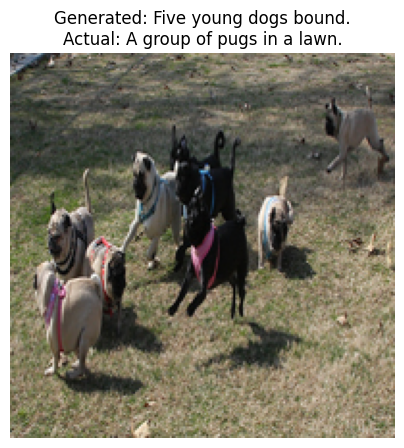

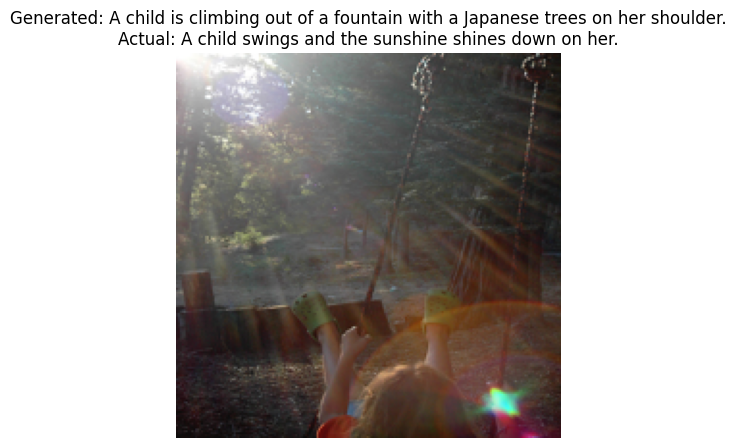

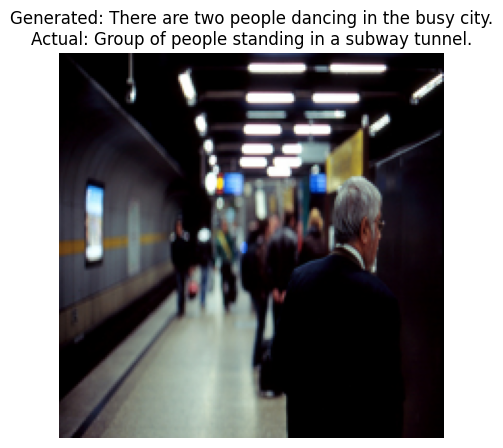

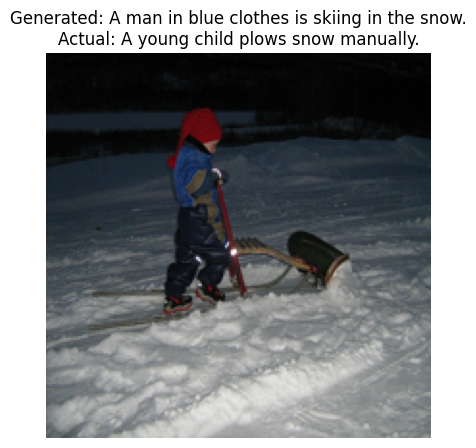

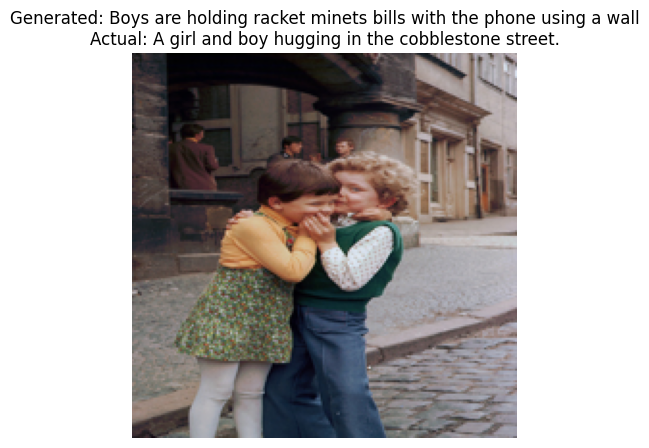

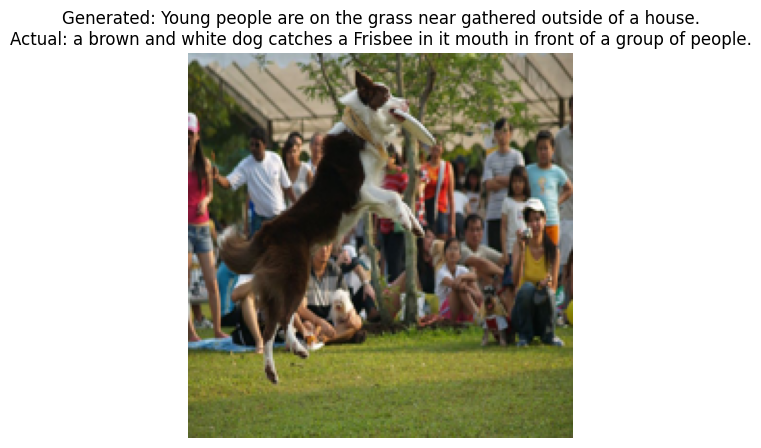

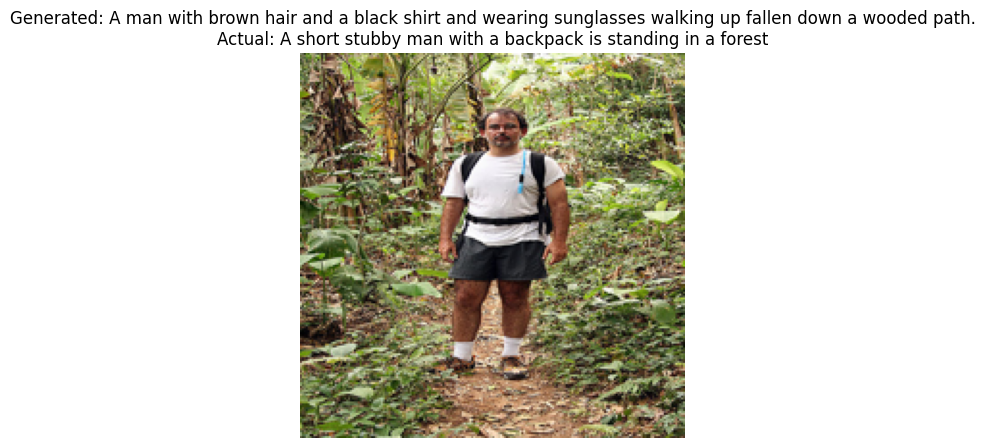

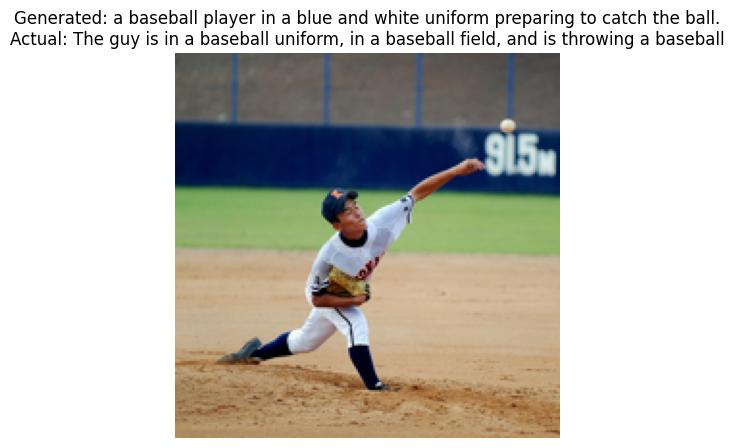

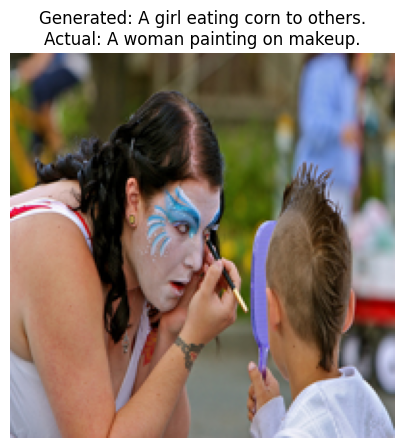

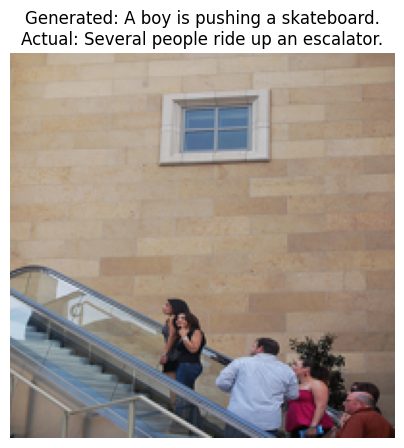

In [ ]:
display_img_captions(image_folder, n_samples = 10)

## Final comments

1. Our model is doing a decent job of capturing the general idea of the images, but it struggles with specific details. It seems to specifically struggle with counting the number of actors or objects in a given image. Unfortunately, it also seems to occasionally hallucinate nonsensical words (e.g., "minets"). Considering how unique each of these images are (all the different variations of cameras, angles, lighting, actions and objects within the scene, etc.), and how our model is not specialized on any particular type or category of images, this unexceptional result is not surprising.
2. To improve the performance of our image captioning model, we could consider the following:
   1. **Model Architecture**: We could explore more advanced architectures, such as using a pre-trained transformer model like BERT or GPT-4.
   2. **Training Dataset**: Using a larger and more diverse dataset could help the model learn better representations of images and captions. Alternatively, we could use a more specialized dataset to train our model to caption a specific type of image.
   3. **Hyperparameter Tuning**: Experimenting with different hyperparameters, such as learning rate, batch size, and number of epochs, could help improve the model's performance. We could also try different optimizers or learning rate schedules to see if they yield better results.

Thanks to Dr. Varada Kolhatkar for her invaluable help and guidance throughout this project.